In [65]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.patches import Ellipse
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from hmmlearn.hmm import GaussianHMM

print(os.getcwd())
# os.chdir('../')
print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


In [3]:
df = pd.read_csv('wbl_05_22_super_sabbatical_processed.csv')


Summary descriptive statistics

In [4]:
list(df.columns)

['groupId',
 'playerId',
 'AwarenessMonitoringGrowth_aggregated_normGrowthMindset',
 'AwarenessMonitoringGrowth_aggregated_normSelfAwareness',
 'AwarenessMonitoringGrowth_aggregated_normSelfMonitoring',
 'AwarenessMonitoringGrowth_aggregated_rawGrowthMindset',
 'AwarenessMonitoringGrowth_aggregated_rawSelfAwareness',
 'AwarenessMonitoringGrowth_aggregated_rawSelfMonitoring',
 'AwarenessMonitoringGrowth_raw_canAdjust',
 'AwarenessMonitoringGrowth_raw_emotionalIntuition',
 'AwarenessMonitoringGrowth_raw_fixedIntelligence',
 'AwarenessMonitoringGrowth_raw_goingOnAroundMe',
 'AwarenessMonitoringGrowth_raw_innermostThoughts',
 'AwarenessMonitoringGrowth_raw_onlyLearnNewThings',
 'AwarenessMonitoringGrowth_raw_othersThinkOfMe',
 'AwarenessMonitoringGrowth_raw_tellInappropriate',
 'AwarenessMonitoringGrowth_raw_troubleChanging',
 'AwarenessMonitoringGrowth_time_seconds',
 'CulturalConflictNorms_aggregated_normConflictOpenness',
 'CulturalConflictNorms_aggregated_rawConflictOpenness',
 'Cultur

In [5]:
# Calculate the total number of participants
total_participants = df['playerId'].nunique()

# Calculate the total number of dyads (assuming dyads are represented by 'groupid')
total_dyads = df['groupId'].nunique()

# Calculate the gender breakdown
gender_counts = df['demographics_gender'].value_counts(normalize=True) * 100  # Percentage breakdown
male_percentage = gender_counts.get('male', 0.0)
female_percentage = gender_counts.get('female', 0.0)
unknown_percentage = gender_counts.get('', 0.0)

df['age'] = 2024 - df['demographics_birth_year']

# Calculate age statistics (mean and standard deviation)
mean_age = df['age'].mean()
std_age = df['age'].std()


print(f"Total participants: {total_participants}")
print(f"Total dyads: {total_dyads}")
print(f"Gender breakdown: {male_percentage:.1f}% male, {female_percentage:.1f}% female, {unknown_percentage:.1f}% unknown")
print(f"Mean age: {mean_age:.1f} years, SD: {std_age:.1f} years")

Total participants: 94
Total dyads: 47
Gender breakdown: 32.6% male, 67.4% female, 0.0% unknown
Mean age: 22.9 years, SD: 6.5 years


In [6]:
# For Agreement reached

subset = df[['groupId', 'deal_sheet_agreement_binary']]

group_counts = subset.groupby('groupId')['deal_sheet_agreement_binary'].value_counts().unstack(fill_value=0)

two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]

print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 43
Number of groupIds with 1 YES and 1 NO: 1
Number of groupIds with 2 NOs: 2


In [7]:
# For Trip reached

subset = df[['groupId', 'deal_sheet_trip_binary']]


group_counts = subset.groupby('groupId')['deal_sheet_trip_binary'].value_counts().unstack(fill_value=0)


two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]


print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 39
Number of groupIds with 1 YES and 1 NO: 5
Number of groupIds with 2 NOs: 2


In [8]:
# For Return Fund reached

subset = df[['groupId', 'deal_sheet_return_fund_binary']]


group_counts = subset.groupby('groupId')['deal_sheet_return_fund_binary'].value_counts().unstack(fill_value=0)


two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]


print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 25
Number of groupIds with 1 YES and 1 NO: 14
Number of groupIds with 2 NOs: 7


Clustering on Task and Relationship

In [10]:
# Calculate Task Conflict and Relationship Conflict for each group
df['Task_Conflict'] = df[['post_negotiation_conflict_1', 'post_negotiation_conflict_2']].mean(axis=1)
df['Relationship_Conflict'] = df[['post_negotiation_conflict_3', 'post_negotiation_conflict_4']].mean(axis=1)

# Group by groupID and calculate the average Task and Relationship Conflict for each group
group_conflicts = df.groupby('groupId')[['Task_Conflict', 'Relationship_Conflict']].mean().reset_index()

In [70]:
# Group by groupID and calculate the average Task and Relationship Conflict for each group
# group_conflicts = df.groupby('groupId')[['Task_Conflict', 'Relationship_Conflict', 'Cluster_Label']].mean().reset_index()

# Calculate the Pearson correlation
correlation, p_value = stats.pearsonr(group_conflicts['Task_Conflict'], group_conflicts['Relationship_Conflict'])

# Degrees of Freedom (n - 2, where n is the number of data points)
n = len(group_conflicts)  # Number of groups
degrees_of_freedom = n - 2

# Display the results
print(f"Pearson Correlation Coefficient: {correlation:.2f}")
print(f"P-Value: {p_value:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")

Pearson Correlation Coefficient: 0.31
P-Value: 0.0328
Degrees of Freedom: 45


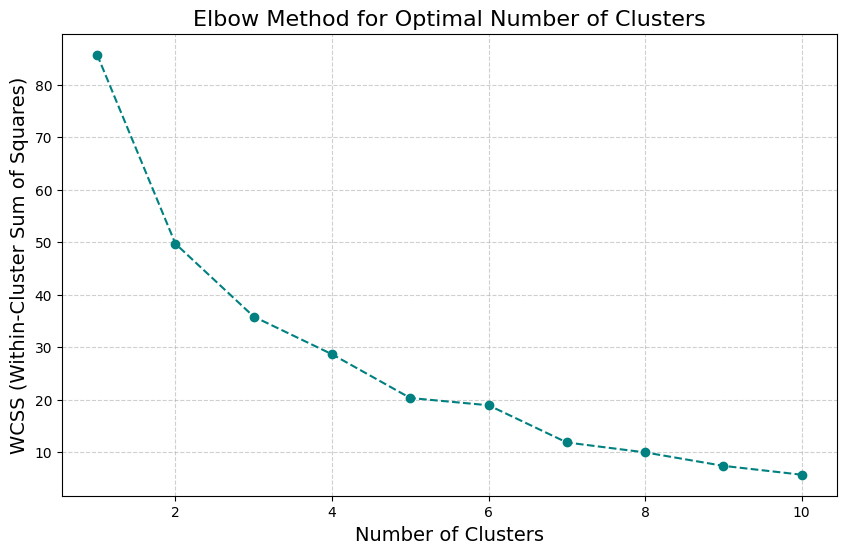

In [13]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
max_clusters = 10  # Maximum number of clusters to test

for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(group_conflicts[['Task_Conflict', 'Relationship_Conflict']])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--', color='teal')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=14)
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

                       groupId  Task_Conflict  Relationship_Conflict  Cluster  \
0   01HYGGKFHG8BZ3KW7ZDR0KGC4N           6.75                   3.50        1   
1   01HYGGM69HQN5GHTMDC1D1M24W           5.00                   3.00        1   
2   01HYGGMT9R24HQ95866Y6BBDES           5.25                   2.25        1   
3   01HYGGNS7A8Y691JXB24RMZ83G           6.50                   3.50        1   
4   01HYGGNVDW9MXKDB9T4WG2GW8M           3.00                   1.00        0   
5   01HYGGPM8PPG1XP0ZX8JQH9BHH           5.25                   2.25        1   
6   01HYGGPVVFQ5KKAYPXSWBQ5GX2           3.75                   2.50        0   
7   01HYGGQ7PWKMP8E7DR30SQ7YQ0           5.75                   4.00        1   
8   01HYGGQDQ90NV6F5XQ253XWHK3           6.00                   2.25        1   
9   01HYGGQDQCG0Q9FK0NAQDNHQXK           4.00                   4.00        1   
10  01HYGGQH1YTD0YH3Q79X4HKEQH           6.00                   3.25        1   
11  01HYGGR7XVC5XVR3XY0DSB0E

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


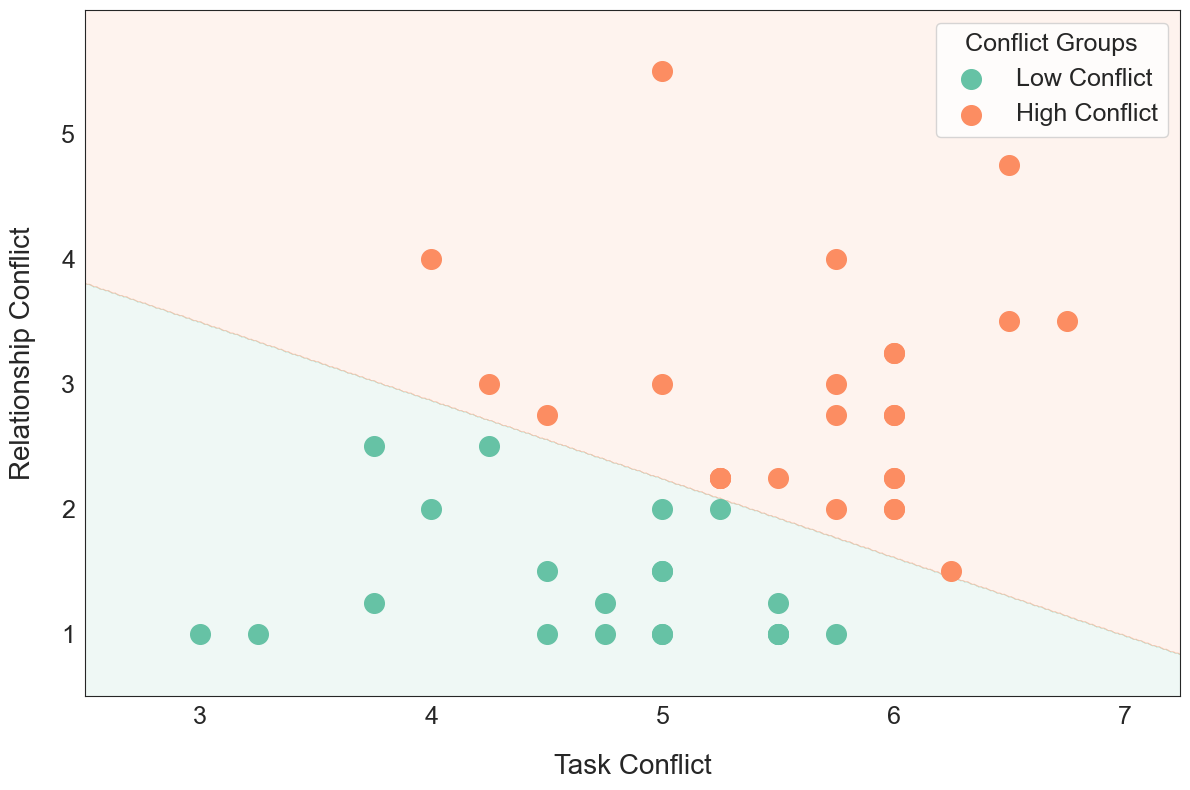

In [14]:
optimal_clusters = 2  # Update this based on the elbow point observed

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
group_conflicts['Cluster'] = kmeans.fit_predict(group_conflicts[['Task_Conflict', 'Relationship_Conflict']])


# Relabel the clusters
group_conflicts['Cluster_Label'] = group_conflicts['Cluster'].replace({0: 'Low Conflict', 1: 'High Conflict', 2: 'Moderate Conflict'})

print(group_conflicts)
# Save the groups, cluster IDs, and average conflict scores to a CSV file
# output_file_path = './Output/super_May22/group_clusters.csv'
# group_conflicts.to_csv(output_file_path, index=False)

# Generate a mesh grid for shading the cluster areas
x_min, x_max = group_conflicts['Task_Conflict'].min() - 0.5, group_conflicts['Task_Conflict'].max() + 0.5
y_min, y_max = group_conflicts['Relationship_Conflict'].min() - 0.5, group_conflicts['Relationship_Conflict'].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict the cluster for each point in the mesh grid
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the clustering results
plt.figure(figsize=(12, 8))
sns.set_style("white")  # Minimalist grid
palette = sns.color_palette("Set2", optimal_clusters)

# Plot the shaded cluster boundaries
plt.contourf(xx, yy, Z, alpha=0.1, cmap=ListedColormap(palette))

# Scatter plot for each cluster
for cluster in range(optimal_clusters):
    cluster_data = group_conflicts[group_conflicts['Cluster'] == cluster]
    plt.scatter(
        cluster_data['Task_Conflict'], 
        cluster_data['Relationship_Conflict'], 
        s=200,  # Larger points
        label=f"{cluster_data['Cluster_Label'].iloc[0]}", 
        color=palette[cluster], 
        # edgecolor='black', 
        # linewidth=0.5 
        alpha=1  # Slight transparency for elegance
    )
    

# Add cluster labels directly to areas
# cluster_centers = kmeans.cluster_centers_
# for i, (center_x, center_y) in enumerate(cluster_centers):
#     plt.text(
#         center_x, 
#         center_y, 
#         f"{group_conflicts['Cluster_Label'].unique()[i]}", 
#         fontsize=15, 
#         weight='bold', 
#         color='black', 
#         ha='center', 
#         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3')
#     )

# Add centroids
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', edgecolor='white', linewidth=2)

# Axis labels and title
plt.xlabel('Task Conflict', fontsize=20, labelpad=18)
plt.ylabel('Relationship Conflict', fontsize=20, labelpad=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Legend (optional if cluster labels are inside areas)
plt.legend(fontsize=18, loc='upper right', frameon=True, title='Conflict Groups', title_fontsize=18)

# Save and show the plot
plt.tight_layout()
plt.savefig('./Output/super_May22/clean_cluster_plot.png', dpi=300)
plt.show()

Segmenting conversations by conflict cluster

In [91]:
df_text = pd.read_csv('./Output/super_May22/Text_agg.csv')

In [104]:
# Extract the last 6 characters from PairID and groupId
df_text['MergeKey'] = df_text['PairID'].str[-6:]
group_conflicts['MergeKey'] = group_conflicts['groupId'].str[-6:]

# Perform a left join
merged_data = df_text.merge(group_conflicts, on='MergeKey', how='left')

# Drop the temporary MergeKey column if not needed
# merged_data.drop(columns=['MergeKey'], inplace=True)


cutoff_data = []
for convo_id, group in merged_data.groupby('PairID'):
    total_time = group['Start Time'].max()
    
    if total_time == 0:
        # If total_time is 0, default everything to "Opening"
        group['Stage'] = 0
    else:     
        # Assign stages based on cutoffs
        stage_labels = []
        for time in group['Start Time']:
            if time <= 0.25 * total_time:
                stage_labels.append(0)
            elif time <= 0.50 * total_time:
                stage_labels.append(1)
            elif time <= 0.75 * total_time:
                stage_labels.append(2)
            else:
                stage_labels.append(3)
        
        group['Stage'] = stage_labels
    
    # Store results
    cutoff_data.append(group)

# Combine results
merged_data = pd.concat(cutoff_data, ignore_index=True)

merged_data.to_clipboard()

In [107]:
summary = (
    merged_data.groupby(['Cluster_Label', 'Stage'])
    .agg(
        avg_turns=('Turn', lambda x: x.groupby(merged_data.loc[x.index, 'PairID']).count().mean()),
        std_turns=('Turn', lambda x: x.groupby(merged_data.loc[x.index, 'PairID']).count().std(ddof=1)),
        se_turns=('Turn', lambda x: x.groupby(merged_data.loc[x.index, 'PairID']).count().std(ddof=1) / 
                 np.sqrt(x.groupby(merged_data.loc[x.index, 'PairID']).count().count())),
        avg_wordcount=('word_count', 'mean'),
        std_wordcount=('word_count', 'std'),
        n_wordcount=('word_count', 'count'),
        avg_sentiment=('Sentiment', 'mean'),
        std_sentiment=('Sentiment', 'std'),
        n_sentiment=('Sentiment', 'count'),
        avg_contested=('Contested', 'mean'),
        std_contested=('Contested', 'std'),
        n_contested=('Contested', 'count'),
        typical_start_time=('Start Time', 'mean'),
        typical_end_time=('End Time', 'mean')
    )
    .reset_index()
)

summary['avg_duration'] = summary['typical_end_time'] - summary['typical_start_time']

summary['se_wordcount'] = summary['std_wordcount'] / np.sqrt(summary['n_wordcount'])
summary['se_sentiment'] = summary['std_sentiment'] / np.sqrt(summary['n_sentiment'])
summary['se_contested'] = summary['std_contested'] / np.sqrt(summary['n_contested'])


summary = summary.melt(id_vars= ['Cluster_Label', 'Stage'])
summary = summary.pivot(index = ['Cluster_Label', 'variable'],columns='Stage')
print(summary)

# Save the summary
merged_data.to_csv("./Output/super_May22/Segmented_Conversations_With_Conflicts.csv")
summary.to_csv("./Output/super_May22/Conflict_Group_Stage_Summary.csv")

                                       value                          \
Stage                                      0           1           2   
Cluster_Label variable                                                 
High Conflict avg_contested         0.260492    0.310524    0.342026   
              avg_duration         11.370304   14.467681   13.800271   
              avg_sentiment         0.122338    0.095563    0.108055   
              avg_turns            27.520000   22.880000   23.440000   
              avg_wordcount        24.572674   30.755245   26.861775   
              n_contested         688.000000  572.000000  586.000000   
              n_sentiment         688.000000  572.000000  586.000000   
              n_wordcount         688.000000  572.000000  586.000000   
              se_contested          0.016580    0.019245    0.019467   
              se_sentiment          0.008920    0.009186    0.009004   
              se_turns              2.976642    2.591216    3.20

In [103]:
file_path = "./Output/super_May22/Conflict_Group_Stage_Summary.csv"
summary = pd.read_csv(file_path, skiprows=2)

/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_11267/3507282805.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


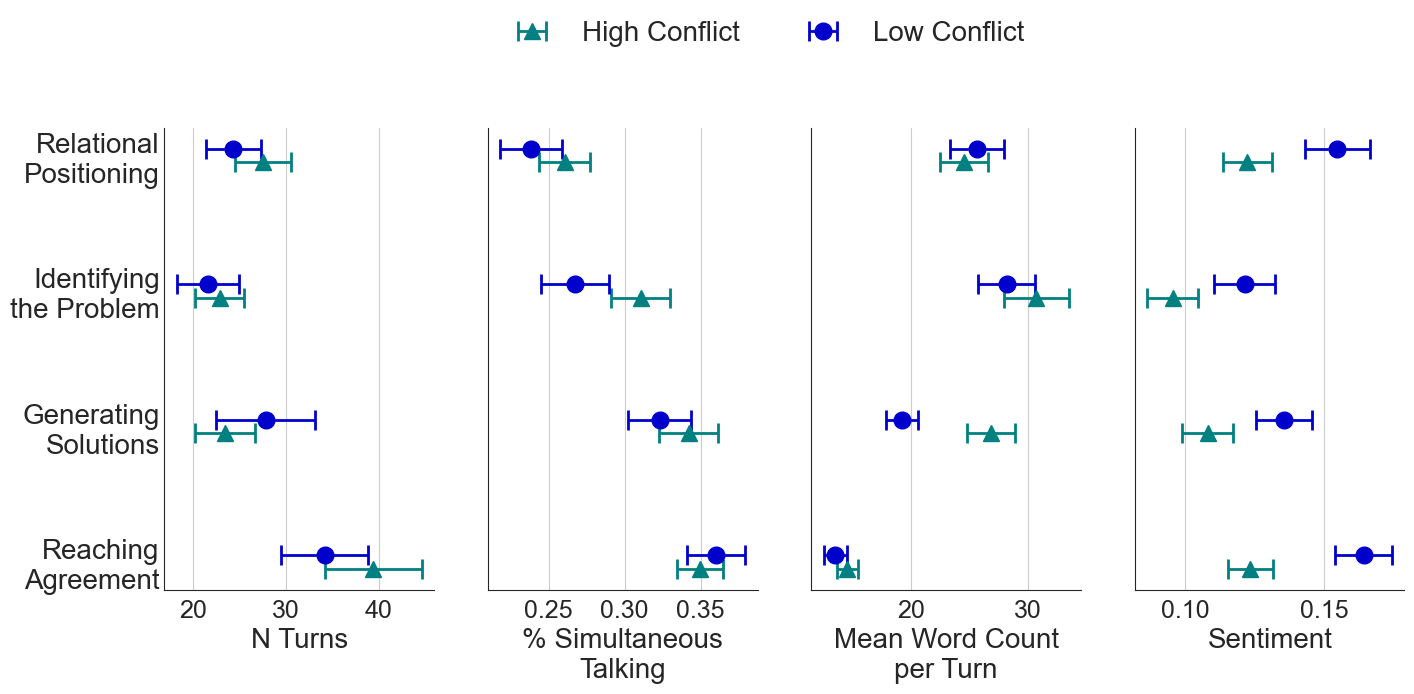

In [108]:
# Load the CSV file
file_path = "./Output/super_May22/Conflict_Group_Stage_Summary.csv"
summary = pd.read_csv(file_path, skiprows=2)

# Rename columns appropriately
summary.rename(columns={'Unnamed: 0': 'Cluster_Label', 'variable': 'Variable', 
                        'Unnamed: 2': 0, 'Unnamed: 3': 1, 'Unnamed: 4': 2, 'Unnamed: 5': 3}, inplace=True)

# Melt the DataFrame to long format for easier plotting
summary = summary.melt(id_vars=['Cluster_Label', 'Variable'], var_name='Stage', value_name='Value')

# Convert 'Stage' column to numeric
summary['Stage'] = summary['Stage'].astype(int)

# Extract standard errors rows
se_summary = summary[summary['Variable'].str.startswith('se_')].copy()
se_summary['Variable'] = se_summary['Variable'].str.replace('se_', 'avg_')

# Merge standard errors back into the main dataframe
summary = summary.merge(se_summary, on=['Cluster_Label', 'Variable', 'Stage'], suffixes=('', '_se'))

# Correct the stage order so that the labels match the data points
stage_order = {0: 3, 1: 2, 2: 1, 3: 0}
summary["Stage"] = summary["Stage"].map(stage_order)

# Define formatted stage labels with multi-line formatting
formatted_stage_labels = {
    0: "Reaching\nAgreement",
    1: "Generating\nSolutions",
    2: "Identifying\nthe Problem",
    3: "Relational\nPositioning"
}

# Define cluster names, colors, and marker styles
cluster_names = {"Low Conflict": "Low Conflict", "High Conflict": "High Conflict"}
colors = {"Low Conflict": "#0000cd", "High Conflict": "#008080"}
markers = {"Low Conflict": "o", "High Conflict": "^"}
offset = .05  
larger_marker_size = 12  

# Define metric order and labels with multi-line formatting
ordered_metrics = ["avg_turns", "avg_contested", "avg_wordcount", "avg_sentiment"]
ordered_se_metrics = ["se_turns", "se_contested", "se_wordcount", "se_sentiment"]
metric_labels = {
    "avg_turns": "N Turns",
    "avg_contested": "% Simultaneous\nTalking",
    "avg_wordcount": "Mean Word Count\nper Turn",
    "avg_sentiment": "Sentiment"
}


# Create the figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True, gridspec_kw={'wspace': 0.2})

for i, (metric, std_metric) in enumerate(zip(ordered_metrics, ordered_se_metrics)):
    ax = axes[i]
    subset = summary[summary['Variable'] == metric]
    
    for cluster in subset['Cluster_Label'].unique():
        cluster_name = cluster_names[cluster]  # Rename clusters
        cluster_subset = subset[subset['Cluster_Label'] == cluster]
        ax.errorbar(
            cluster_subset['Value'],
            cluster_subset['Stage'] - (offset if cluster_name == "High Conflict" else -offset),  
            xerr=cluster_subset['Value_se'],
            fmt=markers[cluster_name],  # Use different marker styles
            color=colors[cluster_name],
            markersize=larger_marker_size,  # Larger markers
            label=cluster_name if i == 0 else "",
            capsize=7,  # Larger caps for error bars
            capthick=2,  # Thicker error bar caps
            elinewidth=2  # Increase error bar line thickness
        )

    ax.set_xlabel(metric_labels[metric], fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Keep x-axis ticks
    ax.tick_params(axis='y', length=0)  # Remove only the y-axis tick marks
    ax.set_yticks(list(formatted_stage_labels.keys()))
    ax.set_yticklabels([formatted_stage_labels[stage] for stage in formatted_stage_labels], fontsize=20)
    
    
    # Remove all horizontal grid lines and keep only vertical grid lines
    ax.grid(False)  # Remove all grid lines first
    ax.grid(axis='x', color='grey', alpha=0.4)  # Add only vertical lines

    # Remove top and right borders of each subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Remove y-axis title
axes[0].set_ylabel("")

# Move legend to a more central position
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=20, frameon=False)

# Improve layout
plt.tight_layout()
plt.show()